# Statistika valov

Prikazali bomo osnovne statistične operacije na časovnih signalih meritve višine valov. Enake prijeme lahko nato uporabite za vse ostale tipe meritev.

Poleg obdelave podatkov, bo prikazano tudi napredna uporaba izrisov rezultatov.

Glavni del algoritma je iskanje para točk, ki določa prehodno stanje naključnega vala. Pogoj za par je določen kot prehod čez linijo $z=0$ ali $\eta=0$, kjer je točka $P_1$ nad in točka $P_2$ pod nivojem $\eta=0$.

Iskanje indeksa $k$, kjer se to zgodi je narejen v funkciji *find_next_zero_crossing(eta, i, mm)*, kjer je *eta* vektor podatkov meritev amplitude, *i* je indeks, od koder naj prične z iskanjem in *mm* velikost vektorja *eta*.

In [1]:
import math as mat
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl # knjižnjica za plot

# MatPlotLib set fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['DejaVu Serif']

# MatPlotLib set LaTeX use
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}'

In [2]:
# prebere podatke iz excel datoteke

def read_excel_data(file_name):
    
    data = pd.read_excel(file_name)
    head = list(data.columns)
    
    print('head: ', head)
    
    t = data[head[0]]
    h = data[head[1]]
    
    return [t.size, np.array([t,h])]

In [3]:
# naredi povprečitev signala po zaporednih oknih, kjer je določimo korak n in širino m okna 

def get_averaged_signal(data, n, m, NN):
    
    T = data[0]
    H = data[1]
    data_avg_T = []
    data_avg_H= []
    
    k = 0
    while k < NN:
        data_avg_T.append(np.mean(data[0,k:k+m]))
        data_avg_H.append(np.mean(data[1,k:k+m]))
        k += n
        
    return np.array([data_avg_T, data_avg_H])    

In [4]:
#poišče naslednji valovni prehod navzdol čez ničlo 

def find_next_zero_crossing(eta, i, mm):
    
    if i+1 == mm:
        return mm
    
    h1 = eta[i]
    k = i + 1
    h2 = eta[k]
    # print('start({:d}): h1={:.3f}, h2={:.3f}'.format(i,h1,h2))
    
    # izvaja dokler ni sign(h1) > sign(h2)
    while not (mat.copysign(1, h1) > mat.copysign(1, h2)) :
        if k+1 == mm:
            return mm
        
        h1 = eta[k]
        k += 1
        h2 = eta[k]
        # print('  -> ({:d}): h1={:.3f}, h2={:.3f}'.format(k,h1,h2))
        
    return k

In [5]:
# poišči periodo in višino zero-crossing vala

def get_period_height(data, i, mm):
    
    j = find_next_zero_crossing(data[1],i,mm)
    if j+1 >= mm:
        return [-1,0,0]
    
    # print('i={:d}, j={:d}'.format(i,j))
    # print('ti=[{:.3f},{:.3f}], tj=[{:.3f},{:.3f}]'.format(data[0][i-1],data[0][i],data[0][j-1],data[0][j]))
    # print('hi=[{:.3f},{:.3f}], hj=[{:.3f},{:.3f}]'.format(data[1][i-1],data[1][i],data[1][j-1],data[1][j]))
    
    H = np.max(data[1,i:j]) - np.min(data[1,i:j])
    # določi čas zero-crossing z linearno interpolacijo
    t1 = data[0,i-1] + data[1,i-1]/(data[1,i-1] - data[1,i])*(data[0,i] - data[0,i-1]) 
    t2 = data[0,j-1] + data[1,j-1]/(data[1,j-1] - data[1,j])*(data[0,j] - data[0,j-1])
    T = t2 - t1
    
    # print('({:d}->{:d}): H={:.3f}, T={:.3f}; t1={:.3f}, t2={:.3f}'.format(i,j,H,T,t1,t2))
    
    return [j,T,H]

In [6]:
def get_wave_period_height(data):
    
    mm = data.shape[1]
    print('wave datasize:', mm)
    i = find_next_zero_crossing(data[1],0,mm)
    
    TH_data = []
    
    while i > 0:            
        [i,T,H] = get_period_height(data,i,mm)
        if i > 0:
            TH_data.append([T,H])
        
    TH = np.array(TH_data)
    return np.transpose(TH)

In [7]:
def get_wave_statistics(TH):
    
    mm = TH.shape[1]
    mmS = int(mm/3)
    print('mm=', mm)
    print('mms=',mmS)
    
    T = TH[0]
    H = TH[1]
    
    # mean
    T_mean = np.mean(T)
    H_mean = np.mean(H)
    
    # significant
    print(T)
    print(np.sort(T))
    T = np.sort(T)[mmS:mm]
    T_s = np.mean(T)
    
    H = np.sort(H)[mmS:mm]
    H_s = np.mean(H)
    
    return [[T_mean,H_mean],[T_s,H_s]]

### Statistika podatkov

Najprej moramo ponastaviti **sampling rate*** signal na željeno vrednost. Recimo, če je zahteva po 3s intervalu in imamo meritev v 0.5s intervalu, moramo narediti ustrezno preslikavoo podatkov. Spodaj je prikaz dveh *naivnih* načinov takšne preslikave:

- izločitev vsakega 6-tega podatka
- povprečitev 6-ih podatkov

Statistična primerjava kaže razliko. Kaj je prav, oziroma kaj je bolj smiselno, presodite sami!

In [8]:
# branje podatkov

file_name = '../00_data_setup/wave_generator/wave_time_data.xlsx'
[size, data] = read_excel_data(file_name)

head:  ['time [s]', 'wave amplitude [m]']


In [9]:
# povprečevanje iz 0.5s na 3s, z okensko funkcijo

n = 3
m = 6   # pazi: 6*0.5s = 3s
data_avg = get_averaged_signal(data, n, m, size)

In [10]:
# jemanje vsakega n-tega

n = 6
data_nth = data[:,::n]

In [11]:
# statistika surovih podatkov 

TH_data = get_wave_period_height(data)

stat = get_wave_statistics(TH_data)

print()
print('       mean: T = {:.3f} s, H = {:.3f} m'.format(stat[0][0], stat[0][1]))
print('significant: T = {:.3f} s, H = {:.3f} m'.format(stat[1][0], stat[1][1]))

wave datasize: 21600
mm= 1322
mms= 440
[ 6.19322837  9.2286544  10.38169299 ...  6.91924242  5.97016329
 10.24456094]
[ 1.16112427  1.33572061  1.39117866 ... 15.03294305 15.32013686
 15.4570663 ]

       mean: T = 8.160 s, H = 2.960 m
significant: T = 9.709 s, H = 3.771 m


In [12]:
# statistika izbranih podatkov 

TH_data = get_wave_period_height(data_nth)

stat = get_wave_statistics(TH_data)

print()
print('       mean: T = {:.3f} s, H = {:.3f} m'.format(stat[0][0], stat[0][1]))
print('significant: T = {:.3f} s, H = {:.3f} m'.format(stat[1][0], stat[1][1]))

wave datasize: 3600
mm= 1110
mms= 370
[ 5.72195858  8.68107045 12.27636193 ... 11.89557866 18.46858419
 10.83341355]
[ 3.18697866  3.37485754  3.37664181 ... 16.97675675 18.46858419
 19.91960939]

       mean: T = 9.720 s, H = 2.602 m
significant: T = 11.164 s, H = 3.260 m


In [13]:
# statistika povprečenih podatkov

TH_data = get_wave_period_height(data_avg)

stat = get_wave_statistics(TH_data)

print()
print('       mean: T = {:.3f} s, H = {:.3f} m'.format(stat[0][0], stat[0][1]))
print('significant: T = {:.3f} s, H = {:.3f} m'.format(stat[1][0], stat[1][1]))

wave datasize: 7200
mm= 1140
mms= 380
[ 6.09352312  8.949469   10.55562079 ... 12.16549003 17.79782214
 10.94636923]
[ 2.16578227  2.27190845  2.47229343 ... 16.9759095  17.41623545
 17.79782214]

       mean: T = 9.463 s, H = 2.393 m
significant: T = 10.891 s, H = 3.014 m


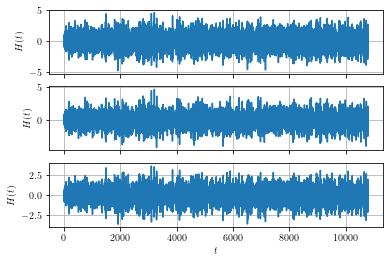

In [14]:
# Izris originalnih in filtriranih podatkov

fig, ax = mpl.subplots(3)

ax[0].plot(data[0],data[1])
ax[0].set_xticklabels([])
ax[0].set_ylabel('$H(t)$')
ax[0].grid()

ax[1].plot(data_nth[0],data_nth[1])
ax[1].set_xticklabels([])
ax[1].set_ylabel('$H(t)$')
ax[1].grid()

ax[2].plot(data_avg[0],data_avg[1])
ax[2].set_xlabel('$t$')
ax[2].set_ylabel('$H(t)$')
ax[2].grid()

In [15]:
# Prikaz statistike filtriranih podatkov v odvisnosti od dolžine koraka n

m = 6   # pazi: 6*0.5s = 3s
nv = range(1,m+1)

for n in nv:
    data_avg = get_averaged_signal(data, n, m, size)
    TH_data = get_wave_period_height(data_avg)
    
    stat = get_wave_statistics(TH_data)

    print('filter okno: n = {:d}, m = {:d}'.format(n,m))
    print('       mean: T = {:.3f} s, H = {:.3f} m'.format(stat[0][0], stat[0][1]))
    print('significant: T = {:.3f} s, H = {:.3f} m'.format(stat[1][0], stat[1][1]))
    print()

wave datasize: 21600
mm= 1157
mms= 385
[ 6.16381512  8.95680041 10.49381365 ...  4.69715868 13.19487079
 10.83953051]
[ 1.36990466  2.24194753  2.24936048 ... 15.71795154 17.06905624
 17.37598862]
filter okno: n = 1, m = 6
       mean: T = 9.324 s, H = 2.479 m
significant: T = 10.744 s, H = 3.127 m

wave datasize: 10800
mm= 1149
mms= 383
[ 6.20412831  8.90390424 10.49778378 ... 12.10445394 17.86179484
 10.89933367]
[ 1.53385063  1.58547324  1.82284215 ... 17.19018603 17.69957908
 17.86179484]
filter okno: n = 2, m = 6
       mean: T = 9.389 s, H = 2.451 m
significant: T = 10.807 s, H = 3.089 m

wave datasize: 7200
mm= 1140
mms= 380
[ 6.09352312  8.949469   10.55562079 ... 12.16549003 17.79782214
 10.94636923]
[ 2.16578227  2.27190845  2.47229343 ... 16.9759095  17.41623545
 17.79782214]
filter okno: n = 3, m = 6
       mean: T = 9.463 s, H = 2.393 m
significant: T = 10.891 s, H = 3.014 m

wave datasize: 5400
mm= 1119
mms= 373
[ 6.08816214  9.03811157 10.49265964 ... 12.07676563 17.7465